## The following topics are proposed to be covered:

1. #### Python for scientific computing: Numpy an introduction
    1. Vectorization - how to achieve higher performance in iterated operations. Numpy is a precompiled and optimized library / package within Python that is written in Cython (which is a wrapper for C in Python). Vectorization of code essentially pushes the operations into the precompiled layer of Numpy which allows higher performance that is more or less equivalent to that of C.
    2. Using Numba and Cython to write *typed* code which will run faster, and again, be more or less equivalent to the performance of C.
    
1. #### Pandas in Python for dataset analysis and visualization
    1. Why Pandas?
    2. How to read in data, perform preliminary operations to index it correctly
    3. How to clean the data, remove null values etc.
    3. Perform basic dataset operations
    3. Visualization of data
    
1. #### Jupyter notebooks - To promote reproducibility and collaboration in Science
    1. What are *Jupyter Notebooks*?
    1. How can one create and share their entire scientific workflow in such a manner that it becomes easily understandable and easily reproduced

## Let us begin with Numpy

In [1]:
import numpy as np

pArr = [i for i in range(10000)]
pArr[1] = 1.

In [2]:
print(type(pArr), type(pArr[0]), type(pArr[1]), type(pArr[2]) )

<class 'list'> <class 'int'> <class 'float'> <class 'int'>


We have created a list in Python called *pArr*. Python uses dynamic typing as seen above. Whenever Python code runs, the compiler checks each element for its type before performing operations on it. This imposes an overhead on operations on lists or arrays that need to be done on every element in the list.

In [3]:
%%timeit
for i in range(10000):
    pArr[i] = pArr[i] + 1.

1000 loops, best of 3: 898 µs per loop


Now let's create a Numpy array

In [8]:
nArr = np.arange(10000)

In [9]:
nArr

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [10]:
print(type(nArr), type(nArr[0]) )

<class 'numpy.ndarray'> <class 'numpy.int64'>


In [12]:
%%timeit
nArr[:] = nArr[:] + 1.

The slowest run took 30.91 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 18.5 µs per loop


In [13]:
type(nArr[0])

numpy.int64

In [9]:
679/18.2

37.30769230769231

We created an integer array called nArr and we add a float 1.0 to every element, we see that there is a 37 times speedup in the code. Can we make it better by ensuring that the type of variables being operated on remain the same?

In [14]:
npfloatArr = np.linspace(0.,1000000.,1.)

In [11]:
print(type(npfloatArr), type(npfloatArr[0]) )

<class 'numpy.ndarray'> <class 'numpy.float64'>


In [15]:
%%timeit
npfloatArr[:] = npfloatArr[:] + 1.

The slowest run took 29.69 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 961 ns per loop


In [13]:
679/.816

832.1078431372549

**By ensuring that the type of the variable remains the same, ie. all are float64, here we achieve an 832 times improvement in performance!**

In [14]:
pArr = [i for i in range(1000000)]

In [13]:
from numba import double
from numba.decorators import jit, autojit
import numba

In [91]:
def myloop_python():
    for i in range(1000000):
        pArr[i] = pArr[i] + 1

In [92]:
myloop_numba = autojit(myloop_python)
%timeit myloop_numba()

1 loop, best of 3: 111 ms per loop


In [93]:
%timeit myloop_python()

10 loops, best of 3: 71.5 ms per loop


In [94]:
%%timeit
@numba.jit
def myloop_python():
    for i in range(1000000):
        pArr[i] = pArr[i] + 1

10000 loops, best of 3: 85.2 µs per loop


Again, we see that there is an improvement in performance, an 8 times improvement, but not as much as we saw with Numpy vectorization. What is going on here?

In [2]:
import cython
import pstats, cProfile
%load_ext Cython

In [6]:
%%cython
import time
start = time.time()
cdef myCloop():
    cdef int i=0
    cdef int cArr[1000000]
    for i in range(1000000):
        cArr[i] = 1 + 2
        
myCloop()
print("Total time = "+str(time.time() - start)+" s")

Total time = 7.152557373046875e-07 s


Numpy seems to be about as fast as Cython, 0.9$\mu s$ vs 3.1$\mu s$

In [97]:
%%timeit
nArr = np.zeros(1000000)
nArr[:] = 1 + 2

1000 loops, best of 3: 1.24 ms per loop


When we increase the size of arrays involved, we see that Cython beats Numpy. **For large arrays, Cython would be the better choice.** However, for most applications, such as the usual Linear Algebra operations, there are libraries available within **Scipy**. Their algorithms are **optimised** for performance and studies show that they are comparable to C when it comes to large data sizes.

### Let's look at an example of Poisson's equation

$$\frac{d^2 \theta}{dx^2} + \frac{d^2 \theta}{dy^2} = 0 $$

For the following BC:
$\theta_{x=0} = 1$

The Discretized form of the equation is:
$$\frac{\theta_{(i-1),j} - 2\theta_{i,j} + \theta_{(i+1),j}}{\Delta x^2} + \frac{\theta_{i,(j-1)} - 2\theta_{i,j} + \theta_{i,(j+1)}}{\Delta y^2} = 0 $$

Writing the same in the traditional way with loops would produce the following function:

In [4]:
def compute_Poissons_looped(N=100):
    theta = np.zeros((N,N))
    
    dx = 1./float(N)
    
    
    theta[:,0] = 1.
    counter = 0
    while(counter < 10):
        for i in range(1,N-1,1):
            for j in range(1,N-1, 1):
                theta[i,j] = (theta[i,j+1] + theta[i,j-1] + theta[i+1,j] + theta[i-1,j]) * 0.25
        counter+=1
            

In [7]:
%%timeit
#import time
#start = time.time()
compute_Poissons_looped(N=500)
#print "total time elapsed = "+str(time.time() - start)

1 loop, best of 3: 2.04 s per loop


In [8]:
def compute_Poissons_vectorized(N=10000):
    theta = np.zeros((N,N))
    dx = 1./float(N)
    theta[:,0] = 1.
    counter = 0
    while(counter<10):
        theta[1:-1,1:-1] = (theta[1:-1, 2:] + theta[1:-1, :-2] + theta[2:, 1:-1] + theta[:-2, 1:-1] ) * 0.25
        counter+=1
        
    return theta

In [10]:
%%timeit
#start = time.time()
compute_Poissons_vectorized(N=500)
#print "total time elapsed = "+str(time.time() - start)

100 loops, best of 3: 10.2 ms per loop


In [11]:
2.04/10.2e-3

200.0

So we see a 155 $\times$ speedup between vectorized and pure python code. Let's try out the pure python code with a numba jit call:

In [14]:
@numba.jit
def compute_Poissons_numba(N=10000):
    theta = np.zeros((N,N))
    
    dx = 1./float(N)
    
    
    theta[:,0] = 1.
    counter = 0
    while(counter < 10):
        for i in range(1,N-1,1):
            for j in range(1,N-1, 1):
                theta[i,j] = (theta[i,j+1] + theta[i,j-1] + theta[i+1,j] + theta[i-1,j]) * 0.25
        counter+=1

In [15]:
%%timeit
#start = time.time()
compute_Poissons_numba(N=500)
#print "total time elapsed = "+str(time.time() - start)

The slowest run took 32.32 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 13 ms per loop


Numba and Numpy seem to be similar in performance, let's test with larger array sizes

In [17]:
%%timeit
compute_Poissons_vectorized(N=10000)

1 loop, best of 3: 6.8 s per loop


In [18]:
%%timeit
compute_Poissons_numba(N=10000)

1 loop, best of 3: 5.51 s per loop


In [31]:
%%cython
from cpython cimport array
import array
import numpy as np
cimport numpy as np
import time

start = time.time()
cdef compute_Poissons_cython(N=1000):
    cdef int i=0
    cdef int j=0
    cdef int counter =0
    theta = np.zeros((N,N))
    theta[:,0] = 1.
    cdef double [:, :] Theta = theta
        
    while(counter < 10):
        for i in range(1,N-1,1):
            for j in range(1,N-1,1):
                Theta[i,j] = (Theta[i,j+1] + Theta[i,j-1] + Theta[i+1,j] + Theta[i-1,j]) * 0.25
        counter+=1
            
compute_Poissons_cython(N=10000)

print("Total time = "+str(time.time() - start)+" s")

Total time = 5.524340629577637 s


The pure Python function was solving only a 500 $\times$ 500 array, and it took 2.04s

The Numba, Numpy, and Cython methods solve a $10^4 \times 10^4$ array in about 6s. Numpy is written in Cython

Cython allows low level management of memory, advanced users may make use of this to improve the performance of the code.

In [19]:
%%cython
import numpy as np
cimport numpy as np
import time

DTYPE = np.float64

start = time.time()
cdef compute_Poissons_cython(N=1000):
    cdef int i=0
    cdef int j=0
    cdef int counter =0
    cdef np.ndarray Theta = np.zeros([N, N], dtype=DTYPE)    
    for i in range(N):
        Theta[i][0] = 1.
        
    while(counter < 10):
        for i in range(1,N-1,1):
            for j in range(1,N-1,1):
                Theta[i,j] = (Theta[i,j+1] + Theta[i,j-1] + Theta[i+1,j] + Theta[i-1,j]) * 0.25
        counter+=1
            
compute_Poissons_cython(N=1000)

print("Total time = "+str(time.time() - start)+" s")

Total time = 6.886895179748535 s


In [ ]:
%%cython
import numpy as np
import time

start = time.time()
cdef compute_Poissons_cython():
    cdef int i=0
    cdef int j=0
    cdef int counter =0
    
    cdef double Theta[10][10]
    cdef int N = 10
    #setting all values to zero
    for i in range(N):
        for j in range(N):
            Theta[i][j] = 0.
    #setting BC
    for i in range(N):
        Theta[i][0] = 1.
    counter = 0
    i = 1
    j=1
    while(counter < 10):
        for i in range(1,N-1,1):
            for j in range(1,N-1,1):
                Theta[i][j] = (Theta[i][j+1] + Theta[i][j-1] + Theta[i+1][j] + Theta[i-1][j]) * 0.25
        print(Theta, "\n \n")        
        counter= counter + 1
        
        
    
            
compute_Poissons_cython()

print("Total time = "+str(time.time() - start)+" s")

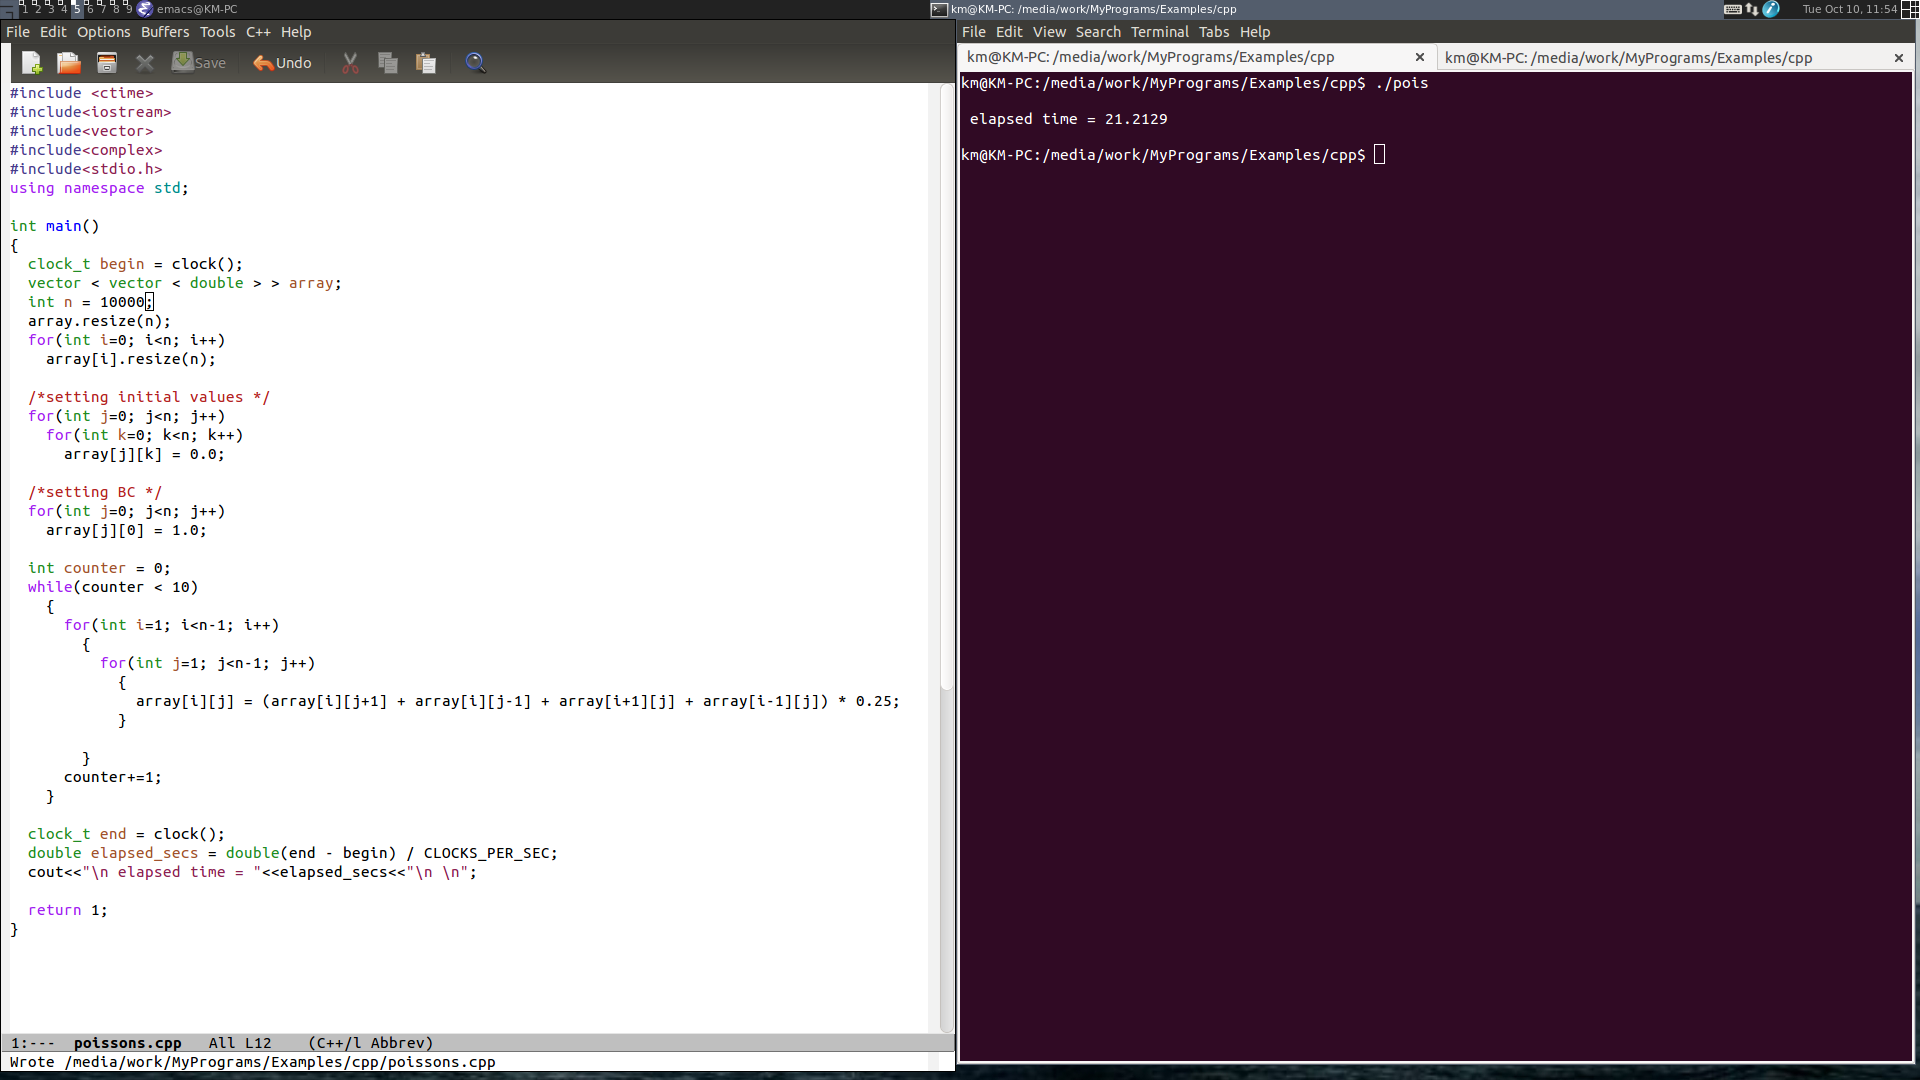

In [20]:
from IPython.display import Image
Image("cppPois.png")

Why is C++ code taking 21s for a 10,000 X 10,000 array? Something seems wrong here!!